<h1 style="font-size:3rem;color:#325B74;">Lab 4</h1>

## Ethical aspects of data

## 4.1 Fairness metrics for synthetic datasets


In [26]:
#we import all the required libraries
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # for generating synthetic data 
from sklearn import datasets #For real datasets
SEED = 1122334455
import pandas as pd
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

In [27]:
from sklearn.svm import SVC
from sklearn import metrics

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

In [28]:
def generate_synthetic_data_bias():

    """
        Code for generating the synthetic data.
        We will have two features and a binary class.
        
    """

    n_samples = 20 # generate these many data points per class
    #For biased data
    p_sen=0.2 #this parameter sets the probability of being protected (sensitive feature=1)
    delta1=[3,-2] # This is the increment of the mean for the positive class
    delta2=[3,-2] # This is the increment of the mean for the negative class
    
    
    def gen_gaussian_sensitive(size, mean_in, cov_in, class_label, sensitive):
        nv = multivariate_normal(mean = mean_in, cov = cov_in)
        X = nv.rvs(size)
        y = np.ones(size, dtype=int) * class_label
        x_sen = np.ones(size, dtype=float) * sensitive
        return nv,X,y,x_sen

    """ Generate the features randomly """
    #For the NON-protected group (sensitive feature=0, for ex. men)
    # We will generate one gaussian cluster for each class
    mu1, sigma1 = [2, 2], [[5, 1], [1, 5]]
    mu2, sigma2 = [-2,-2], [[10, 1], [1, 3]]
    nv1, X1, y1, x_sen1= gen_gaussian_sensitive(int((1-p_sen)*n_samples), mu1, sigma1, 1,0) # positive class
    nv2, X2, y2, x_sen2= gen_gaussian_sensitive(int((1-p_sen)*n_samples),mu2, sigma2, 0,0) # negative class
    
    
    #For the Protected group (sensitive feature=1, for ex. women)
    # We will generate one gaussian cluster for each class
    mu3, sigma3 = np.add(mu1,delta1), [[5, 1], [1, 5]]
    mu4, sigma4 = np.add(mu2,delta2), [[10, 1], [1, 3]]
    nv3, X3, y3, x_sen3 = gen_gaussian_sensitive(int(p_sen*n_samples), mu3, sigma3, 1,1.) # positive class
    nv4, X4, y4, x_sen4 = gen_gaussian_sensitive(int(p_sen*n_samples),mu4, sigma4, 0,1.) # negative class
    

    

    # join the positive and negative class clusters
    X = np.vstack((X1, X2, X3, X4))
    y = np.hstack((y1, y2, y3, y4))
    x_prot= np.hstack((x_sen1, x_sen2, x_sen3, x_sen4))
    

    # shuffle the data
    perm = list(range(0,n_samples*2))
    shuffle(perm)
    X = X[perm]
    y = y[perm]
    x_prot=x_prot[perm]
    
    

    return X,y,x_prot

In [29]:
X_syn, y_syn, x_bias = generate_synthetic_data_bias()

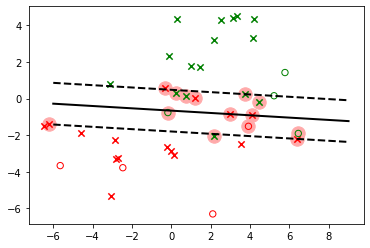

In [30]:
#plt.scatter(X_syn[y_syn==1][:, 0], X_syn[y_syn==1][:, 1], color='#378661', marker='x', s=40, linewidth=1.5, label= "Class +1")
#plt.scatter(X_syn[y_syn==0][:, 0], X_syn[y_syn==0][:, 1], color='#A73730', marker='x', s=40, linewidth=1.5, label = "Class -1")

X_s_0 = X_syn[x_bias == 0.0]
X_s_1 = X_syn[x_bias == 1.0]
y_s_0 = y_syn[x_bias == 0.0]
y_s_1 = y_syn[x_bias == 1.0]

# SVM Classifier model
#the hyperparameter C control the margin violations
#smaller C leads to more margin violations but wider margin

svm_clf = SVC(kernel="linear", C=float(4))
svm_clf.fit(X_syn, y_syn)

plot_svc_decision_boundary(svm_clf, -6, 9)
plt.scatter(X_s_0[y_s_0==1][:, 0], X_s_0[y_s_0==1][:, 1], color='green', marker='x', s=40, linewidth=1.5, label= "Non-prot. +1")
plt.scatter(X_s_0[y_s_0==0][:, 0], X_s_0[y_s_0==0][:, 1], color='red', marker='x', s=40, linewidth=1.5, label = "Non-prot. -1")
plt.scatter(X_s_1[y_s_1==1][:, 0], X_s_1[y_s_1==1][:, 1], color='green', marker='o', facecolors='none', s=40, label = "Prot. +1")
plt.scatter(X_s_1[y_s_1==0][:, 0], X_s_1[y_s_1==0][:, 1], color='red', marker='o', facecolors='none', s=40, label = "Prot. -1")

#plt.savefig('aggre.png')
plt.show()

First we calculate the accuracy of the SVM classifier in our dataset:

In [31]:
#Accuracy
y_pred=svm_clf.predict(X_syn)

print("Accuracy: %.1f" % (metrics.accuracy_score(y_syn, y_pred)*100), "%")


Accuracy: 82.5 %


We first implement the equal opportunity metric:

In [32]:
#Let us now implement the equal opportunity metric:
def equal_opportunity(y,y_pred, x_prot):
    Pos_pro=0.0
    Pos_nonpro=0.0
    PPos_pro=0.0
    PPos_nonpro=0.0
    
    n=y_pred.size

    for i in range(0,n):
        if (y[i]==1 and x_prot[i]==0):
            Pos_nonpro=Pos_nonpro+1
            if (y_pred[i]==1):
                PPos_nonpro=PPos_nonpro+1
        if (y[i]==1 and x_prot[i]==1):
            Pos_pro=Pos_pro+1
            if (y_pred[i]==1):
                PPos_pro=PPos_pro+1
    #print(Pos_nonpro)
    #print(Pos_pro)
    #print(PPos_pro)
    #print(PPos_nonpro)
    UNF_EOpp=abs((PPos_nonpro/Pos_nonpro)-(PPos_pro/Pos_pro))
    
    return UNF_EOpp


In [33]:
UNF_EOpp=equal_opportunity(y_syn,y_pred, x_bias)
print('UNF_EOpp = %.2f' % (UNF_EOpp*100),"%")

UNF_EOpp = 43.75 %


In [34]:
#1- Calculate the predictive equality metric for the given dataset and classifier.

def predictive_equality(y,y_pred, x_prot):
    Pos_pro=0.0
    Pos_nonpro=0.0
    PPos_pro=0.0
    PPos_nonpro=0.0
    
    n=y_pred.size

    for i in range(0,n):
        if (y[i]==0 and x_prot[i]==0):
            Pos_nonpro=Pos_nonpro+1
            if (y_pred[i]==1):
                PPos_nonpro=PPos_nonpro+1
        if (y[i]==0 and x_prot[i]==1):
            Pos_pro=Pos_pro+1
            if (y_pred[i]==1):
                PPos_pro=PPos_pro+1
    #print(Pos_nonpro)
    #print(Pos_pro)
    #print(PPos_pro)
    #print(PPos_nonpro)
    UNF_PE =abs((PPos_nonpro/Pos_nonpro)-(PPos_pro/Pos_pro))
    
    return UNF_PE

In [35]:
UNF_PE=predictive_equality(y_syn,y_pred, x_bias)
print('UNF_PE = %.2f' % (UNF_PE*100),"%")

UNF_PE = 25.00 %


In [36]:
#Calculate the equalized odds metric for the given dataset and classifier.

def Equalized_Odds(y,y_pred, x_prot):
    return equal_opportunity(y,y_pred, x_prot) + predictive_equality(y,y_pred, x_prot)
    
UNF_EOdds = Equalized_Odds(y_syn,y_pred, x_bias)
print(UNF_EOdds)

0.6875


In [37]:
#3- Calculate the predictive parity metric for the given dataset and classifier.

def Predictive_parity(y,y_pred, x_prot):
    Pos_pro=0.0
    Pos_nonpro=0.0
    PPos_pro=0.0
    PPos_nonpro=0.0
    
    n=y_pred.size

    for i in range(0,n):
        if (y_pred[i]==1 and x_prot[i]==0):
            Pos_nonpro=Pos_nonpro+1
            if (y[i]==1):
                PPos_nonpro=PPos_nonpro+1
        if (y_pred[i]==1 and x_prot[i]==1):
            Pos_pro=Pos_pro+1
            if (y[i]==1):
                PPos_pro=PPos_pro+1
    #print(Pos_nonpro)
    #print(Pos_pro)
    #print(PPos_pro)
    #print(PPos_nonpro)
    UNF_PE =abs((PPos_nonpro/Pos_nonpro)-(PPos_pro/Pos_pro))
    
    return UNF_PE

In [38]:
UNF_PE=Predictive_parity(y_syn,y_pred, x_bias)
print('UNF_PE = %.2f' % (UNF_PE*100),"%")

UNF_PE = 21.05 %


In [39]:
#4- Calculate the statistical parity metric for the given dataset and classifier.

def statistic_parity(y,y_pred, x_prot):
    Pos_pro=0.0
    Pos_nonpro=0.0
    PPos_pro=0.0
    PPos_nonpro=0.0
    
    n=y_pred.size

    for i in range(0,n):
        if (x_prot[i]==0):
            Pos_nonpro=Pos_nonpro+1
            if (y_pred[i]==1):
                PPos_nonpro=PPos_nonpro+1
        if (x_prot[i]==1):
            Pos_pro=Pos_pro+1
            if (y_pred[i]==1):
                PPos_pro=PPos_pro+1
    #print(Pos_nonpro)
    #print(Pos_pro)
    #print(PPos_pro)
    #print(PPos_nonpro)
    UNF_SP=abs((PPos_nonpro/Pos_nonpro)-(PPos_pro/Pos_pro))
    
    return UNF_SP

In [40]:
UNF_SP=statistic_parity(y_syn,y_pred, x_bias)
print('UNF_PE = %.2f' % (UNF_SP*100),"%")

UNF_PE = 34.38 %


In [41]:
#5- a)Calculate the disparate impact metric for the given dataset and classifier.

def disparate_impact(y,y_pred, x_prot):
    Pos_pro=0.0
    Pos_nonpro=0.0
    PPos_pro=0.0
    PPos_nonpro=0.0
    
    n=y_pred.size

    for i in range(0,n):
        if (x_prot[i]==0):
            Pos_nonpro=Pos_nonpro+1
            if (y_pred[i]==1):
                PPos_nonpro=PPos_nonpro+1
        if (x_prot[i]==1):
            Pos_pro=Pos_pro+1
            if (y_pred[i]==1):
                PPos_pro=PPos_pro+1
    #print(Pos_nonpro)
    #print(Pos_pro)
    #print(PPos_pro)
    #print(PPos_nonpro)
    UNF_DI=min((PPos_pro/Pos_pro)/(PPos_nonpro/Pos_nonpro), (PPos_nonpro/Pos_nonpro)/(PPos_pro/Pos_pro))
    
    return UNF_DI

In [42]:
UNF_DI=disparate_impact(y_syn,y_pred, x_bias)
print('UNF_PE = %.2f' % (UNF_DI*100),"%")

UNF_PE = 42.11 %


In [ ]:
#b)Does this classifier satisfy the 80%-rule?

#No it dosen't respect the 80% rule.



### Questions:


**1-** Calculate the predictive equality metric for the given dataset and classifier.

**2-** Calculate the equalized odds metric for the given dataset and classifier.

**3-** Calculate the predictive parity metric for the given dataset and classifier.

**4-** Calculate the statistical parity metric for the given dataset and classifier.

**5-** a)Calculate the disparate impact metric for the given dataset and classifier.

  b)Does this classifier satisfy the 80%-rule?
  


## 4.2 Fairness metrics for the German dataset

In [43]:
German_data=np.loadtxt('German.txt')
i_prot=40 #the protected features corresponds with column 40 from the txt file
n_sample=500 # we define our training sample size
C_param=5

X_German=np.delete(German_data,[0,i_prot],1) #We eliminate the first column that correspond to labels and the protected feature

y_German=German_data[:,0] #labels
x_bias_german=German_data[:,i_prot] #protected feature

#Now let us consider a training set
X_G=X_German[1:n_sample,:]
y_G=y_German[1:n_sample]
x_bias_G=x_bias_german[1:n_sample]


# SVM Classifier model
#the hyperparameter C control the margin violations
#smaller C leads to more margin violations but wider margin

svm_clf = SVC(kernel="linear", C=float(C_param))
svm_clf.fit(X_G, y_G)

y_pred_G=svm_clf.predict(X_G)

In [44]:
#6- Provide a table with the accuracy and the 6 fairness metrics.

EO = equal_opportunity(y_G,y_pred_G, x_bias_G)
PE = predictive_equality(y_G,y_pred_G, x_bias_G)
EOD= Equalized_Odds(y_G,y_pred_G, x_bias_G)
PP = Predictive_parity(y_G,y_pred_G, x_bias_G)
SP = statistic_parity(y_G,y_pred_G, x_bias_G)
DI = disparate_impact(y_G,y_pred_G, x_bias_G)
mat = ["EO", "PE", "EOD", "PP", "SP", "DI"]
val = [EO, PE, EOD, PP, SP, DI]
pd.DataFrame({"metrics": mat, "values": val})


,metrics,values
0,EO,0.042502
1,PE,0.206343
2,EOD,0.248844
3,PP,0.033378
4,SP,0.118545
5,DI,0.852146


In [ ]:
#Yes it satisfy the 80% rule

In [45]:
i_prot=39 #the protected features corresponds with column 40 from the txt file
n_sample=500 # we define our training sample size
C_param=5

X_German=np.delete(German_data,[0,i_prot],1) #We eliminate the first column that correspond to labels and the protected feature

y_German=German_data[:,0] #labels
x_bias_german=German_data[:,i_prot] #protected feature

#Now let us consider a training set
X_G=X_German[1:n_sample,:]
y_G=y_German[1:n_sample]
x_bias_G=x_bias_german[1:n_sample]


# SVM Classifier model
#the hyperparameter C control the margin violations
#smaller C leads to more margin violations but wider margin

svm_clf = SVC(kernel="linear", C=float(C_param))
svm_clf.fit(X_G, y_G)

y_pred_G=svm_clf.predict(X_G)

In [46]:
#8 Provide a table with the 6 fairness metrics.
EO = equal_opportunity(y_G,y_pred_G, x_bias_G)
PE = predictive_equality(y_G,y_pred_G, x_bias_G)
EOD= Equalized_Odds(y_G,y_pred_G, x_bias_G)
PP = Predictive_parity(y_G,y_pred_G, x_bias_G)
SP = statistic_parity(y_G,y_pred_G, x_bias_G)
DI = disparate_impact(y_G,y_pred_G, x_bias_G)

mat = ["EO", "PE", "EOD", "PP", "SP", "DI"]
val = [EO, PE, EOD, PP, SP, DI]
pd.DataFrame({"metrics": mat, "values": val})



,metrics,values
0,EO,0.021291
1,PE,0.133690
2,EOD,0.154981
3,PP,0.117172
4,SP,0.007337
5,DI,0.990421


In [ ]:
#9
#Yes it satisfy the 80% rule

In [ ]:
#10
#Disparat Impact is way Higher and the fairness metrics are lesser for the men,
#we can say ethat women are disadvantaged in the dataset